In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [20]:
# Inisialisasi StopWordRemover dan Stemmer
stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

stemmer_factory = StemmerFactory() 
stemmer = stemmer_factory.create_stemmer() 

In [21]:
# stopward
def preprocess_text(text):
    # Menghapus stopword
    text_no_stopwords = stopword_remover.remove(text)
    # Melakukan stemming
    text_stemmed = stemmer.stem(text_no_stopwords)
    return text_stemmed 

# non-stopward
# def preprocess_text(text):
#     # Langsung melakukan stemming tanpa menghapus stopword
#     return stemmer.stem(text)

In [22]:
# # Muat data dari file Excel
# data = pd.read_excel('dataset_review.xlsx')

# # Pra-pemrosesan teks
# data['text'] = data['text'].apply(preprocess_text)

# # Misalnya data memiliki kolom 'text' untuk teks dan 'sentiment' untuk label sentimen
# texts = data['text']
# sentiments = data['sentiment'] 

# # Split data menjadi data pelatihan dan data uji
# X_train, X_test, y_train, y_test = train_test_split(texts, sentiments, test_size=0.3, random_state=42)

# Muat data dari file Excel
data = pd.read_excel('REVIEW KEBIJAKAN MBG.xlsx')

# Hapus baris dengan NaN pada kolom 'sentiment'
data['sentiment'] = data['sentiment'].replace('', pd.NA)  # Jika ada string kosong
data = data.dropna(subset=['sentiment']).reset_index(drop=True)

# Pra-pemrosesan teks
data['text'] = data['text'].apply(preprocess_text)

# Ambil kembali kolom
texts = data['text']
sentiments = data['sentiment'] 

# Split data menjadi data pelatihan dan data uji
X_train, X_test, y_train, y_test = train_test_split(
    texts, sentiments, test_size=0.3, random_state=42
)


In [23]:
# Inisialisasi CountVectorizer
vectorizer = CountVectorizer()

# Fit dan transform data pelatihan
X_train_counts = vectorizer.fit_transform(X_train)

# Transform data uji
X_test_counts = vectorizer.transform(X_test) 

In [24]:
print(data['sentiment'].isnull().sum())      # Harus 0
print(X_train.shape, y_train.shape)          # Pastikan cocok
print(X_test.shape, y_test.shape)            # Pastikan cocok


0
(139,) (139,)
(60,) (60,)


In [25]:
from sklearn.naive_bayes import MultinomialNB

# Inisialisasi MultinomialNB
model = MultinomialNB()

# Latih model
model.fit(X_train_counts, y_train)

# Prediksi sentimen untuk data uji
predictions = model.predict(X_test_counts)

In [26]:
# Menampilkan hasil evaluasi
print("Evaluasi Model (NB) dengan Stopword:")
print(classification_report(y_test, predictions))

# Menampilkan beberapa hasil prediksi
print("\nBeberapa hasil prediksi:")
for text, sentiment in zip(X_test, predictions):
    print(f'Teks: {text}\nPrediksi Sentimen: {sentiment}\n')

# Ekspor hasil prediksi ke file Excel
results = pd.DataFrame({'text': X_test, 'predicted_sentiment': predictions})
results.to_excel('predictions(NB)non-sw.xlsx', index=False)

print("Hasil prediksi (NB) telah diekspor ke 'predictions(NB).xlsx'.")

results = pd.DataFrame({'text': X_test, 'true_sentiment': y_test, 'predicted_sentiment': predictions})
results.to_excel('predictions-true(NB)non-sw.xlsx', index=False)

print("Hasil prediksi (NB) telah diekspor ke 'predictions-true(NB).xlsx'.")


Evaluasi Model (NB) dengan Stopword:
              precision    recall  f1-score   support

     Negatif       0.85      0.93      0.89        30
      Netral       0.67      0.67      0.67         9
     Positif       0.94      0.81      0.87        21

    accuracy                           0.85        60
   macro avg       0.82      0.80      0.81        60
weighted avg       0.85      0.85      0.85        60


Beberapa hasil prediksi:
Teks: gizi gimana nanti apa cuma asal kenyang
Prediksi Sentimen: Negatif

Teks: lah bukan lebih penting baik kualitas guru sama fasilitas sekolah makan siang oke kalo guru kurang kompeten sama aja boong dong prioritas kok gin sih
Prediksi Sentimen: Negatif

Teks: jangan program cuma jadi ajang korupsi jamaah
Prediksi Sentimen: Negatif

Teks: kalo makan enak bakal banyak yg makan
Prediksi Sentimen: Negatif

Teks: transparansi anggar kunci
Prediksi Sentimen: Negatif

Teks: ini langkah nyata putus mata rantai miskin
Prediksi Sentimen: Positif

Teks: inv

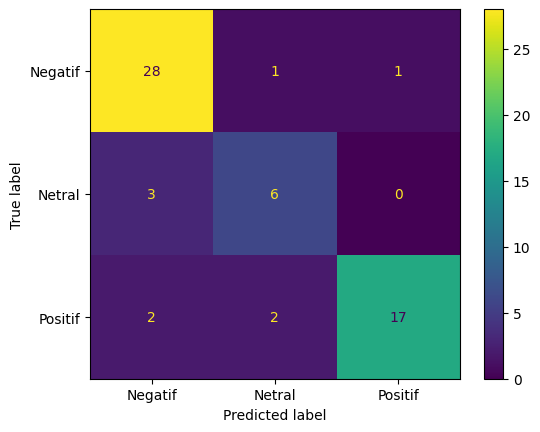

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_counts) 

cm = confusion_matrix(y_test, y_pred, labels=['Negatif', 'Netral', 'Positif'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatif', 'Netral', 'Positif'])
disp.plot()


In [28]:
# Fungsi untuk menganalisis teks baru
def analyze_text(text):
    preprocessed = preprocess_text(text)
    text_counts = vectorizer.transform([preprocessed])
    return model.predict(text_counts)[0]

# Menganalisis teks dari input pengguna
while True:
    user_input = input("\nMasukkan teks untuk analisis sentimen (atau ketik 'x' untuk keluar): ")
    if user_input.lower() == 'x':
        break
    sentiment = analyze_text(user_input)
    print(f'Prediksi Sentimen (NB) untuk "{user_input}": {sentiment}')